In [9]:
"""
Test supervised DSB.
"""
import math
import jax
import jax.numpy as jnp
import numpy as np
import optax
import matplotlib.pyplot as plt
from flax import linen as nn
from fbs.nn.utils import make_nn_with_time
from functools import partial

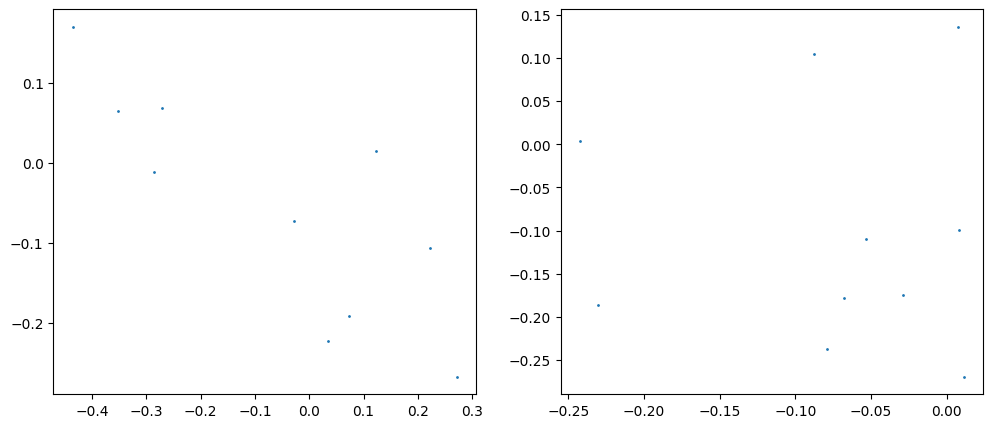

In [10]:
# General configs
nsamples = 10
jax.config.update("jax_enable_x64", True)
nn_param_init = nn.initializers.xavier_normal()
key = jax.random.PRNGKey(666)

dt = 0.01
nsteps = 200
T = nsteps * dt
ts = jnp.linspace(dt, T, nsteps)


# Neural network construction
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=100, param_dtype=jnp.float64, kernel_init=nn_param_init)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=20, param_dtype=jnp.float64, kernel_init=nn_param_init)(x)
        x = nn.gelu(x)
        x = nn.Dense(features=2, param_dtype=jnp.float64, kernel_init=nn_param_init)(x)
        return jnp.squeeze(x)


mlp = MLP()
key, subkey = jax.random.split(key)
init_param, _, nn_eval = make_nn_with_time(mlp, dim_in=2, batch_size=10, key=subkey)

# Draw samples on the two sides
np.random.seed(999)


@partial(jax.vmap, in_axes=[0])
def f1(z):
    """x = f1(z)"""
    u = jnp.sin(0.5 * z)
    return jnp.array([(u[0] + u[1]) / 2, u[0] * u[1]])


@partial(jax.vmap, in_axes=[0])
def f2(x):
    """y = f2(x)"""
    u = jnp.tanh(2 * x)
    return jnp.array([u[0] * u[1], (u[0] + u[1]) / 2])


key, subkey = jax.random.split(key)
zs = jax.random.normal(subkey, (nsamples, 2))
xs = f1(zs)
ys = f2(xs)

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(xs[:, 0], xs[:, 1], s=1)
axes[1].scatter(ys[:, 0], ys[:, 1], s=1)

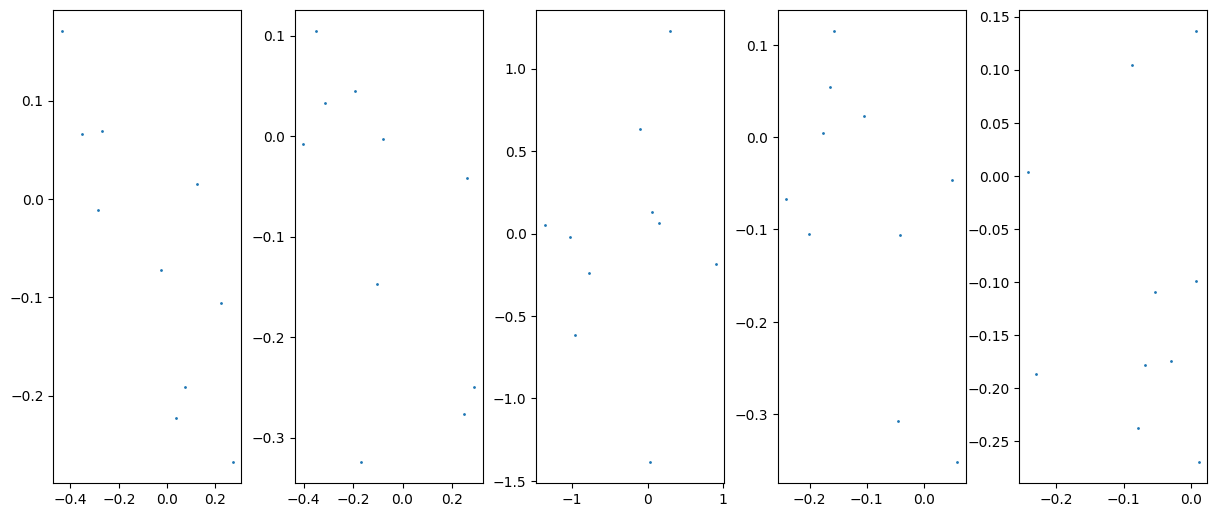

In [11]:
# Define the noising forward reference
def drift(xt, xT, t):
    """Drift of Brownian bridge SDE.
    """
    return (xT - xt) / (T - t)


def simulate_bridge_forward(x0, xT, _key):
    def scan_body(carry, elem):
        x = carry
        t, dw = elem
        x = x + drift(x, xT, t) * dt + dw
        return x, x

    _, _subkey = jax.random.split(_key)
    rnds = math.sqrt(dt) * jax.random.normal(_subkey, (nsteps - 1, 2))
    traj = jax.lax.scan(scan_body, x0, (ts[:-1], rnds))[1]
    return jnp.concatenate([traj, xT.reshape(1, -1)])


key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=nsamples)
trajs = jax.vmap(simulate_bridge_forward, in_axes=[0, 0, 0])(xs, ys, keys)

fig, axes = plt.subplots(ncols=5, figsize=(12, 5))
axes[0].scatter(xs[:, 0], xs[:, 1], s=1)
axes[1].scatter(trajs[:, 0, 0], trajs[:, 0, 1], s=1)
axes[2].scatter(trajs[:, 49, 0], trajs[:, 49, 1], s=1)
axes[-2].scatter(trajs[:, -2, 0], trajs[:, -2, 1], s=1)
axes[-1].scatter(trajs[:, -1, 0], trajs[:, -1, 1], s=1)
plt.tight_layout(pad=0.1)

In [12]:
scales = (T - ts) * ts / (T * dt) + 1e-8


def cond_pdf_t_0(xt, t, xT, x0):
    mt, vt = x0 + t / T * (xT - x0), (T - t) * t / T + 1e-8
    return jnp.sum(jax.scipy.stats.norm.logpdf(xt, mt, jnp.sqrt(vt)), axis=-1)


@partial(jax.vmap, in_axes=[0, None, 0, 0])
@partial(jax.vmap, in_axes=[0, 0, None, None])
def cond_score_t_0(xt, t, xT, x0):
    return jax.grad(cond_pdf_t_0)(xt, t, xT, x0)


def loss_fn(_param, _key, overfit=True):
    if overfit:
        _xs = xs
        _ys = ys
        _keys = jax.random.split(_key, num=nsamples)
    else:
        _key, _subkey = jax.random.split(_key)
        _zs = jax.random.normal(_subkey, (nsamples, 2))
        _xs = f1(zs)
        _ys = f2(xs)
        _keys = jax.random.split(_subkey, num=nsamples)
    forward_paths = jax.vmap(simulate_bridge_forward, in_axes=[0, 0, 0])(_xs, _ys, _keys)  # (nsamples, nsteps, 2)
    errs = (jax.vmap(jax.vmap(nn_eval,
                              in_axes=[0, 0, None]),
                     in_axes=[0, None, None])(forward_paths, ts, _param) -
            cond_score_t_0(forward_paths, ts, _ys, _xs)) ** 2  # (nsamples, nsteps, 2)
    return jnp.sum(jnp.mean(errs, 0))


@jax.jit
def opt_step_kernel(_param, _opt_state, _key):
    _loss, grad = jax.value_and_grad(loss_fn)(_param, _key)
    updates, _opt_state = optimiser.update(grad, _opt_state, _param)
    _param = optax.apply_updates(_param, updates)
    return _param, _opt_state, _loss


optimiser = optax.adam(learning_rate=1e-2)
opt_state = optimiser.init(init_param)
param = init_param

for i in range(10000):
    key, subkey = jax.random.split(key)
    param, opt_state, loss = opt_step_kernel(param, opt_state, subkey)
    print(f'i: {i}, loss: {loss}')

np.save('param_sdsb', param)

i: 0, loss: 1833.8230096945094
i: 1, loss: 2153.925215763152
i: 2, loss: 2367.7157967846683
i: 3, loss: 1953.6414703915393
i: 4, loss: 1918.1173983257886
i: 5, loss: 1508.7669350908718
i: 6, loss: 1789.8278382856438
i: 7, loss: 1264.5541881470688
i: 8, loss: 1478.5470384281728
i: 9, loss: 1088.2375138951131
i: 10, loss: 1558.923829951554
i: 11, loss: 998.0843597491977
i: 12, loss: 1295.2101564488871
i: 13, loss: 1118.6437145939817
i: 14, loss: 1120.0834450834134
i: 15, loss: 1225.7339468506627
i: 16, loss: 1053.1344426460942
i: 17, loss: 1339.5778675010533
i: 18, loss: 1197.1474892476435
i: 19, loss: 1434.9208242118789
i: 20, loss: 1052.6333144108803
i: 21, loss: 965.4472050456294
i: 22, loss: 1216.2334113534355
i: 23, loss: 1168.0789380592034
i: 24, loss: 1188.5909438163262
i: 25, loss: 1049.5185647451806
i: 26, loss: 1219.9789368796085
i: 27, loss: 1074.050547202545
i: 28, loss: 1307.3446988249225
i: 29, loss: 1157.384014645303
i: 30, loss: 1312.3744624156845
i: 31, loss: 1214.554000

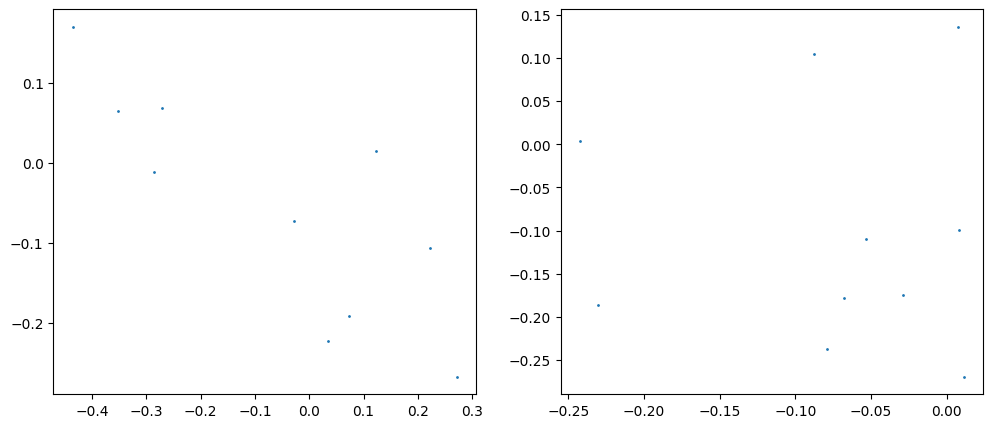

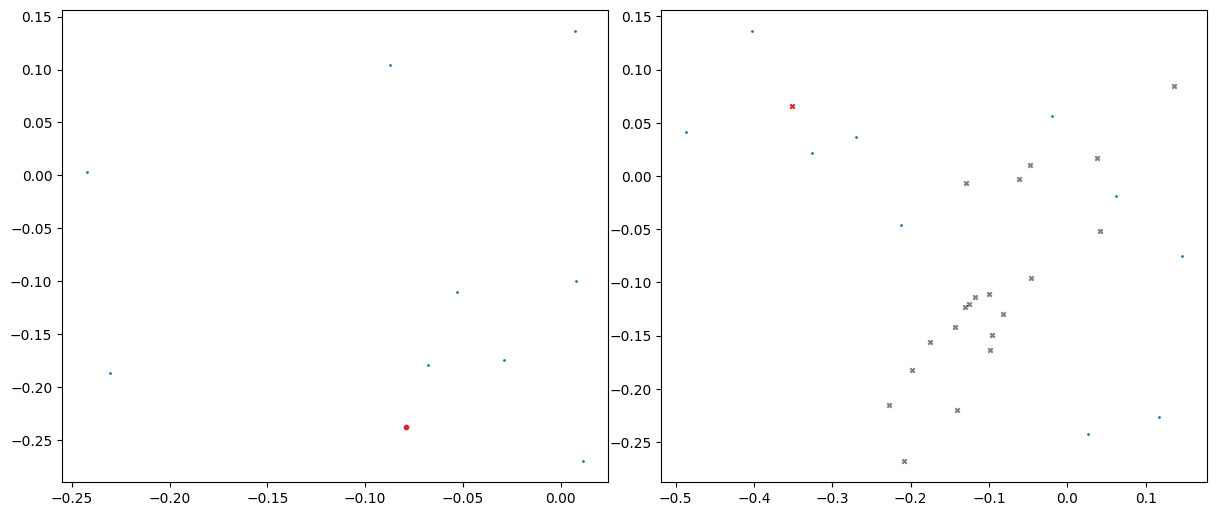

In [28]:
# Backward sampling
def simulate_backward(xT, _key):
    def scan_body(carry, elem):
        x = carry
        t, dw = elem

        x = x + (-drift(x, xT, T - t) + nn_eval(x, T - t, param)) * dt + dw
        return x, x

    _, _subkey = jax.random.split(_key)
    dws = jnp.sqrt(dt) * jax.random.normal(_subkey, (nsteps, 2))
    return jax.lax.scan(scan_body, xT, (ts, dws))[1]


key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=nsamples)
backward_traj = jax.vmap(simulate_backward, in_axes=[0, 0])(ys, keys)

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(xs[:, 0], xs[:, 1], s=1)
axes[1].scatter(ys[:, 0], ys[:, 1], s=1)
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[0].scatter(ys[:, 0], ys[:, 1], s=1)
axes[1].scatter(backward_traj[:, -1, 0], backward_traj[:, -1, 1], s=1)
plt.tight_layout(pad=0.1)

# Mark
idx = 0
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=nsamples)
mark_y = ys[idx]
mark_xs = jax.vmap(simulate_backward, in_axes=[None, 0])(mark_y, keys)
axes[0].scatter(mark_y[0], mark_y[1], s=10, c='tab:red')
axes[1].scatter(mark_xs[:, 0], mark_xs[:, 1], s=10, c='black', alpha=0.5, marker='x')
axes[1].scatter(xs[idx, 0], xs[idx, 1], s=10, c='tab:red', marker='x')